In [1]:
import os
import cv2 as cv2
from pathlib import Path
from google.colab.patches import cv2_imshow
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
import tensorflow as tf

In [2]:
!pwd

/content


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd /content/gdrive/My Drive/Github/AML/Project07/facesDB

/content/gdrive/My Drive/Github/AML/Project07/facesDB


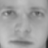

In [6]:
a = cv2.imread("1/1.BMP")
cv2_imshow(a)

In [7]:
input_path = ''

image_df = pd.DataFrame({'path': list(Path(input_path).glob('**/*.BMP'))})
image_df['target'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['image'] = image_df['path'].map(lambda x: x.stem)
image_df['path'] = image_df['path'].map(lambda x: str(x))

In [8]:
image_df.head()

,path,target,image
0,19/10.BMP,19,10
1,19/2.BMP,19,2
2,19/7.BMP,19,7
3,19/4.BMP,19,4
4,19/5.BMP,19,5


In [9]:
# read it in unchanged, to make sure we aren't losing any information
img = cv2.imread(image_df['path'][0])
np.shape(img)

(48, 48, 3)

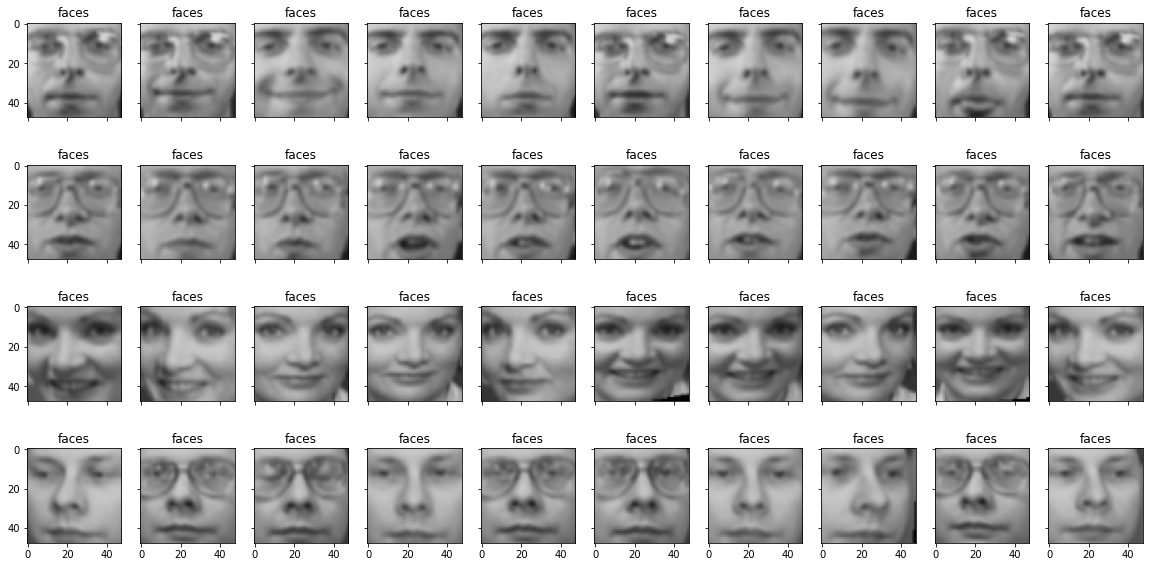

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=10, sharex=True, sharey=True, figsize=(20,10))

ax = ax.flatten()

for i in range(40):
    img = cv2.imread(image_df['path'][i])
    ax[i].imshow(img)
    ax[i].set_title('faces')
    
plt.show()

In [11]:
# split the data into train and test set
train, test = train_test_split(image_df, test_size=0.3, random_state=42, shuffle=True)

# paths
train_path = train['path'].copy().values
test_path = test['path'].copy().values

# labels
train_labels = train['target'].copy().values
test_labels = test['target'].copy().values


In [12]:
train_ds = tf.data.Dataset.from_tensor_slices((train_path, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_path, test_labels))

# note that the `numpy()` function is required to grab the actual values from the Dataset
for path, label in train_ds.take(5):
    print("path  : ", path.numpy().decode('utf-8'))
    print("label : ", label.numpy())

path  :  21/2.BMP
label :  b'21'
path  :  11/1.BMP
label :  b'11'
path  :  2/6.BMP
label :  b'2'
path  :  24/4.BMP
label :  b'24'
path  :  35/5.BMP
label :  b'35'


In [13]:
def cv2_imread(path, label):
    # read in the image, getting the string of the path via eager execution
    img = cv2.imread(path.numpy().decode('utf-8'), cv2.IMREAD_UNCHANGED)
    # change from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, label

def tf_cleanup(img, label):
    # convert to Tensor
    img = tf.convert_to_tensor(img)
    # unclear why, but the jpeg is read in as uint16 - convert to uint8
    img = tf.dtypes.cast(img, tf.uint8)
    # set the shape of the Tensor
    img.set_shape((48, 48, 3))
    # convert to float32, scaling from uint8 (0-255) to float32 (0-1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image
    img = tf.image.resize(img, [48, 48])
    # convert the labels into a Tensor and set the shape
    label = tf.convert_to_tensor(label)
    label.set_shape(())
    return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                        num_parallel_calls=AUTOTUNE)

test_ds = test_ds.map(lambda path, label: tuple(tf.py_function(cv2_imread, [path, label], [tf.uint16, label.dtype])),
                      num_parallel_calls=AUTOTUNE)

train_ds = train_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(tf_cleanup, num_parallel_calls=AUTOTUNE)

In [18]:
# check that the image was read in correctly
for image, label in train_ds.take(1):
    print("image shape : ", image.numpy().shape)
    print("label       : ", label.numpy())

image shape :  (48, 48, 3)
label       :  b'21'


In [17]:
train_ds['image']

TypeError: ignored

In [ ]:
def load_dataset():
  
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
 
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
 
	# one-hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
 
	return trainX, trainY, testX, testY